# ==========================================
# Step 1: Install required libraries
# ==========================================

In [1]:
!pip install ultralytics filterpy opencv-python kaggle matplotlib seaborn --quiet

import os
import cv2
import yaml
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from ultralytics import YOLO
from filterpy.kalman import KalmanFilter
from collections import defaultdict
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from google.colab import files

sns.set_theme(style="darkgrid", font_scale=1.5)
plt.rcParams['figure.figsize'] = [12, 8]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# ==========================================
# Step 2: Download & Prepare Dataset (Kaggle)
# ==========================================

In [2]:
print("Upload your kaggle.json API key to download the dataset.")
uploaded = files.upload()
if 'kaggle.json' not in uploaded:
    raise FileNotFoundError("kaggle.json not uploaded. Please upload your Kaggle API key.")

print("Setting up dataset...")
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d muki2003/yolo-drone-detection-dataset
!unzip -q yolo-drone-detection-dataset.zip -d drone_dataset
!rm yolo-drone-detection-dataset.zip

Upload your kaggle.json API key to download the dataset.


Saving kaggle.json to kaggle.json
Setting up dataset...
Dataset URL: https://www.kaggle.com/datasets/muki2003/yolo-drone-detection-dataset
License(s): other
 76% 272M/359M [00:00<00:00, 810MB/s] 
100% 359M/359M [00:00<00:00, 703MB/s]


# ==========================================
# Step 3: Create YAML Config for YOLOv8
# ==========================================

In [3]:
config = {
    "path": "/content/drone_dataset/drone_dataset",
    "train": "/content/drone_dataset/drone_dataset/train/images",
    "val": "/content/drone_dataset/drone_dataset/valid/images",
    "names": ["drone"],
    "nc": 1
}
with open("/content/data.yaml", "w") as f:
    yaml.dump(config, f)

# ==========================================
# Step 4: Train YOLOv8 Model
# ==========================================

In [25]:
print("\n🚀 Training YOLOv8 model for drone detection ...")
os.environ["WANDB_DISABLED"] = "true"
model = YOLO("yolov8s.pt")

results = model.train(
    data="/content/data.yaml",
    epochs=100,         # More epochs for better learning
    imgsz=640,          # You can try 800 for higher-res if GPU allows
    batch=8,            # Adjust batch size as per GPU capability
    device=0,           # 0 for GPU, -1 for CPU (Colab usually has a GPU)
    patience=12,        # Early stopping patience
    lr0=0.001,          # Initial learning rate (tune as needed)
    optimizer="SGD",    # Try 'SGD' or 'Adam'
    augment=True        # Enable data augmentation for robustness
)
print("\n✅ Training completed.")


🚀 Training YOLOv8 model for drone detection ...
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=12, 

# ==========================================
# Step 5: Evaluate the Model
# ==========================================

In [27]:
metrics = model.val()
print(f"\n📊 Evaluation results:")
print(f"mAP@0.5: {metrics.box.map:.3f}")

Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1498.1±810.6 MB/s, size: 188.3 KB)
val: Scanning /content/drone_dataset/drone_dataset/valid/labels.cache... 347 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 347/347 667.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 44/44 4.2it/s 10.4s
                   all        347        369      0.954      0.891      0.957      0.592
Speed: 0.6ms preprocess, 16.8ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/train33

📊 Evaluation results:
mAP@0.5: 0.592


# ==========================================
# Step 6: Test on Sample Images
# ==========================================


Testing on sample validation images...

image 1/1 /content/drone_dataset/drone_dataset/valid/images/0059.jpg: 384x640 1 drone, 132.8ms
Speed: 2.2ms preprocess, 132.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


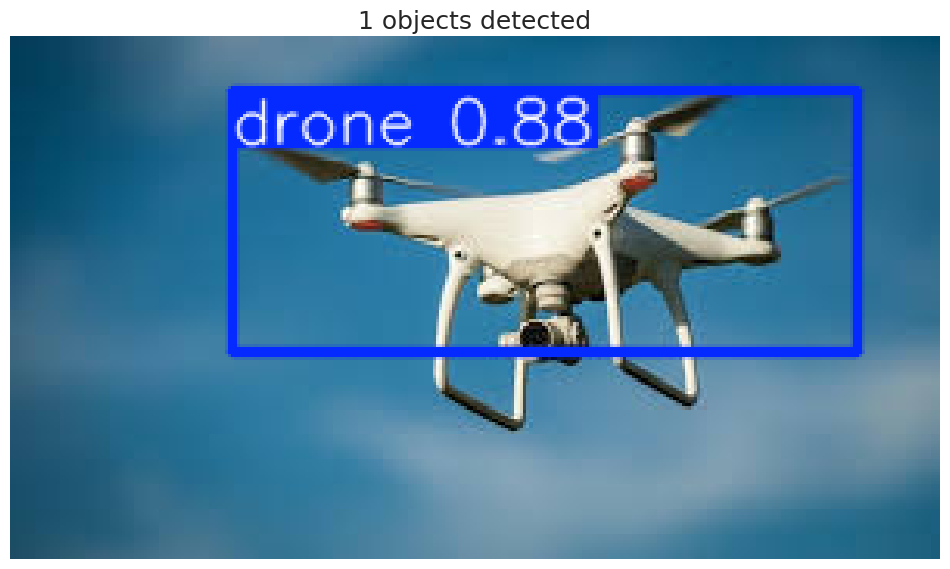


image 1/1 /content/drone_dataset/drone_dataset/valid/images/0049.jpg: 384x640 1 drone, 36.6ms
Speed: 5.7ms preprocess, 36.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


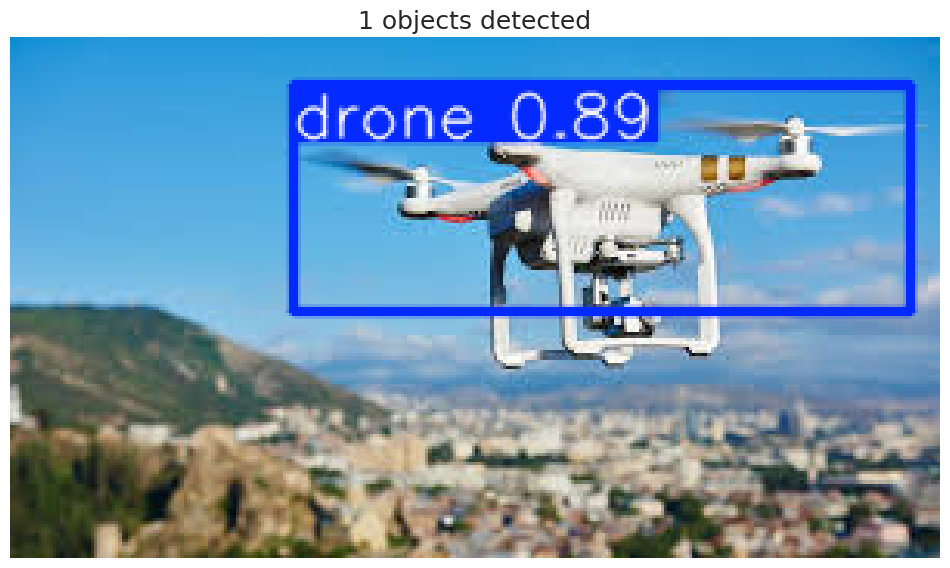


image 1/1 /content/drone_dataset/drone_dataset/valid/images/0001.jpg: 288x640 5 drones, 151.0ms
Speed: 4.6ms preprocess, 151.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


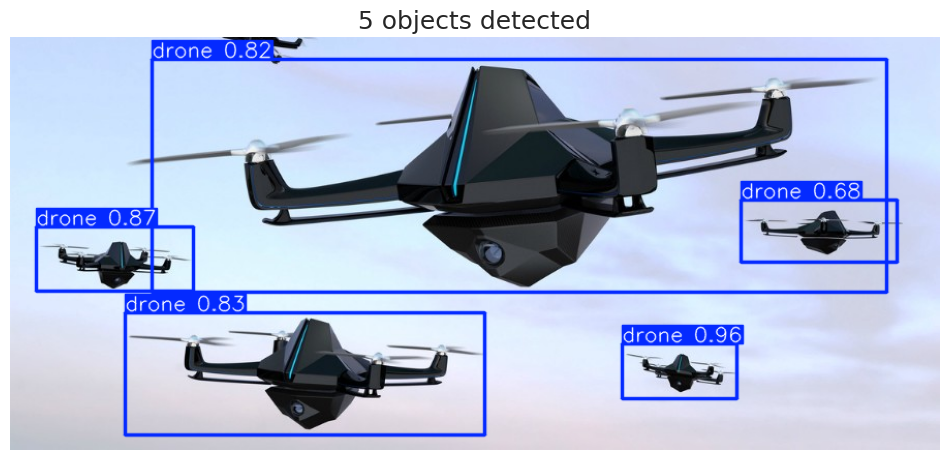

In [28]:
print("\nTesting on sample validation images...")
test_images = glob.glob("/content/drone_dataset/drone_dataset/valid/images/*.jpg")[:3]
for img_path in test_images:
    results = model.predict(img_path, conf=0.5)
    for r in results:
        plt.figure(dpi=100)
        plt.imshow(r.plot()[:,:,::-1])
        plt.title(f"{len(r.boxes)} objects detected" if len(r.boxes) > 0 else "No objects detected")
        plt.axis("off")
        plt.show()

# ==========================================
# Step 7: Video Processing and Tracking Section
# ==========================================

In [19]:
print("\nVideo Processing & Tracking Section")
print("Please upload your drone video file (MP4/AVI/MOV):")
uploaded = files.upload()
video_name = None
for k in uploaded:
    if k.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
        video_name = k
        break
if video_name is None:
    raise FileNotFoundError("No video file uploaded.")

input_path = f"/content/{video_name}"


Video Processing & Tracking Section
Please upload your drone video file (MP4/AVI/MOV):


Saving vecteezy_silhouette-of-modern-drone-with-camera-flying-above-the_37231114.mov to vecteezy_silhouette-of-modern-drone-with-camera-flying-above-the_37231114.mov


# ==========================================
# Step 8: Load Trained Model for Inference
# ==========================================

In [29]:
model_path = "/content/runs/detect/train3/weights/best.pt"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Trained model not found at {model_path}")
model = YOLO(model_path)

# ==========================================
# Step 9: Define Drone Tracker (DeepSORT-inspired with Kalman Filter)
# ==========================================

In [30]:
class DroneTracker:
    def __init__(self):
        self.track_id = 0
        self.tracks = {}              # id: bbox
        self.kalman_filters = {}      # id: KalmanFilter
        self.trajectories = defaultdict(list)
        self.inactive_counts = defaultdict(int)
        self.max_inactive = 30
        self.max_trajectory = 50

    def update(self, detections):
        # Detections: [x1, y1, x2, y2, conf]
        dets = np.array(detections)
        updated_tracks = {}
        active_ids = set()
        matched_det_indices = set()
        if len(dets) > 0 and len(self.tracks) > 0:
            track_centers = np.array([[(t[0]+t[2])/2, (t[1]+t[3])/2] for t in self.tracks.values()])
            det_centers = np.array([[(d[0]+d[2])/2, (d[1]+d[3])/2] for d in dets])
            cost_matrix = distance_matrix(track_centers, det_centers)
            row_ind, col_ind = linear_sum_assignment(cost_matrix)
            for i, j in zip(row_ind, col_ind):
                if cost_matrix[i, j] < 100:
                    tid = list(self.tracks.keys())[i]
                    updated_tracks[tid] = dets[j][:4]
                    active_ids.add(tid)
                    matched_det_indices.add(j)
                    center = [(dets[j][0]+dets[j][2])/2, (dets[j][1]+dets[j][3])/2]
                    kf = self.kalman_filters[tid]
                    kf.predict()
                    kf.update(np.array(center))
                    self.trajectories[tid].append(center)
                    if len(self.trajectories[tid]) > self.max_trajectory:
                        self.trajectories[tid].pop(0)
                    self.inactive_counts[tid] = 0
        # Create new tracks for unmatched detections
        for j in range(len(dets)):
            if j not in matched_det_indices:
                self.track_id += 1
                tid = self.track_id
                updated_tracks[tid] = dets[j][:4]
                active_ids.add(tid)
                center = [(dets[j][0]+dets[j][2])/2, (dets[j][1]+dets[j][3])/2]
                kf = KalmanFilter(dim_x=4, dim_z=2)
                kf.F = np.array([[1,0,1,0], [0,1,0,1], [0,0,1,0], [0,0,0,1]])
                kf.H = np.array([[1,0,0,0], [0,1,0,0]])
                kf.P *= 1000
                kf.R = np.array([[5,0], [0,5]])
                kf.Q = np.eye(4) * 0.01
                kf.x = np.array([center[0], center[1], 0, 0])
                self.kalman_filters[tid] = kf
                self.trajectories[tid].append(center)
                self.inactive_counts[tid] = 0
        self.tracks = updated_tracks
        self._remove_inactive_tracks()
        return self.tracks, self.kalman_filters, self.trajectories

    def _remove_inactive_tracks(self):
        for tid in list(self.tracks.keys()):
            self.inactive_counts[tid] += 1
            if self.inactive_counts[tid] > self.max_inactive:
                del self.tracks[tid]
                del self.kalman_filters[tid]
                del self.trajectories[tid]
                del self.inactive_counts[tid]

# ==========================================
# Step 10: Initialize Video Reader/Writer
# ==========================================

In [31]:
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise IOError("Cannot open video file")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0: fps = 30

output_path = "drone_tracking_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
tracker = DroneTracker()

# Visualization settings
COLORS = {
    'drone': (0, 255, 255),        # Cyan
    'trajectory': (255, 255, 0),   # Yellow
    'prediction': (255, 0, 255)    # Purple
}

# ==========================================
# Step 11: Main Processing Loop (Detection + Tracking)
# ==========================================

In [32]:
frame_count = 0
try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        print(f"Processing frame {frame_count}...")

        # YOLOv8 detection
        results = model(frame, conf=0.3, verbose=False)
        detections = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = box.conf.item()
                # Only take class 'drone' (class 0 for custom model)
                if hasattr(box, 'cls') and int(box.cls.item()) == 0:
                    detections.append([x1, y1, x2, y2, conf])

        # Tracking
        tracks, kfs, trajectories = tracker.update(detections)

        # Visualization
        for tid, bbox in tracks.items():
            x1, y1, x2, y2 = map(int, bbox)
            color = COLORS['drone']
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"Drone {tid}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            if tid in trajectories:
                trajectory = trajectories[tid]
                for i in range(1, len(trajectory)):
                    cv2.line(frame,
                             (int(trajectory[i-1][0]), int(trajectory[i-1][1])),
                             (int(trajectory[i][0]), int(trajectory[i][1])),
                             COLORS['trajectory'], 2)
            if tid in kfs:
                kf = kfs[tid]
                pred_x, pred_y = int(kf.x[0]), int(kf.x[1])
                cv2.circle(frame, (pred_x, pred_y), 5, COLORS['prediction'], -1)
                vel_x, vel_y = int(kf.x[2]), int(kf.x[3])
                cv2.arrowedLine(frame, (pred_x, pred_y),
                               (pred_x + vel_x*5, pred_y + vel_y*5),
                               COLORS['prediction'], 2, tipLength=0.3)

        cv2.putText(frame, f"Drones detected: {len(tracks)}", (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        out.write(frame)
except Exception as e:
    print(f"Error during processing: {e}")
finally:
    cap.release()
    out.release()
    print("Processing completed. Saving output video...")

Processing frame 1...
Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...
Processing frame 16...
Processing frame 17...
Processing frame 18...
Processing frame 19...
Processing frame 20...
Processing frame 21...
Processing frame 22...
Processing frame 23...
Processing frame 24...
Processing frame 25...
Processing frame 26...
Processing frame 27...
Processing frame 28...
Processing frame 29...
Processing frame 30...
Processing frame 31...
Processing frame 32...
Processing frame 33...
Processing frame 34...
Processing frame 35...
Processing frame 36...
Processing frame 37...
Processing frame 38...
Processing frame 39...
Processing frame 40...
Processing frame 41...
Processing frame 42...
Processing frame 43...
Processing frame 44.

# ==========================================
# Step 12: Download Output Video
# ==========================================

In [33]:
if os.path.exists(output_path):
    print(f"✅ Output video saved to {output_path}")
    files.download(output_path)
else:
    print("❌ Error: Output video not created.")

✅ Output video saved to drone_tracking_output.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>